# rs_embed Playground

This notebook demonstrates **direct usage of `get_embedding`** from `rs_embed`,
without any wrapper utilities.

The goal is to clearly expose the **core toolkit API**:
- spatial inputs (`PointBuffer`, `BBox`)
- temporal specs (`year`, `range`)
- output specs (`pooled`, `grid`)
- returned `data` and `meta`

This is intended as a **transparent, reference-style notebook** rather than a benchmarking framework.


In [1]:
from rs_embed import BBox, PointBuffer, TemporalSpec, OutputSpec, get_embedding
from plot_utils import *

import json

## 1. Define spatial and temporal inputs

In [3]:
# Spatial: point + buffer
spatial_point = PointBuffer(
    lon=121.5,
    lat=31.2,
    buffer_m=2048,
)

# Spatial: bounding box
spatial_bbox = BBox(
    minlon=121.45,
    minlat=31.15,
    maxlon=121.50,
    maxlat=31.20,
)

# Temporal: single year
temporal_year = TemporalSpec.year(2024)

# Temporal: date range
temporal_range = TemporalSpec.range(
    "2022-06-01",
    "2022-09-01",
)

spatial_point, spatial_bbox, temporal_year, temporal_range

(PointBuffer(lon=121.5, lat=31.2, buffer_m=2048, crs='EPSG:4326'),
 BBox(minlon=121.45, minlat=31.15, maxlon=121.5, maxlat=31.2, crs='EPSG:4326'),
 TemporalSpec(mode='year', year=2024, start=None, end=None),
 TemporalSpec(mode='range', year=<function TemporalSpec.year at 0x1507ec9a5580>, start='2022-06-01', end='2022-09-01'))

## 2. Precomputed embedding example

- Spatial: `BBox`
- Temporal: `year`
- Output: `grid`


### 2.1 GSE_annual(Alpha Earth)


data.shape: (64, 410, 410)
source: GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL


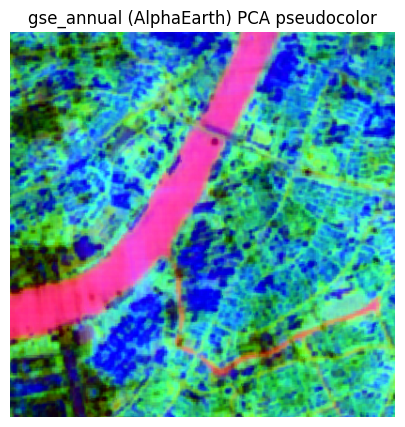

{'mean': array([ 0.07853824, -0.29107493,  0.1161385 , -0.01957924,  0.02499747,
        -0.07961908, -0.09171757, -0.04517604, -0.16079898,  0.08444491,
         0.04607062,  0.04059851, -0.15324387, -0.15063843, -0.11724014,
        -0.11368866,  0.08037771,  0.14151959, -0.07956102,  0.07384185,
        -0.04462529,  0.10088068, -0.10032278,  0.01416243, -0.05940819,
         0.23154068,  0.00040225, -0.0277066 ,  0.15224236,  0.0368964 ,
         0.0367008 ,  0.01560507, -0.07904538, -0.04380777,  0.11977525,
        -0.0081563 , -0.20165128, -0.06312177,  0.05876789,  0.02970741,
        -0.07101694, -0.02973392, -0.0059794 ,  0.04876955,  0.10008385,
         0.16855767, -0.06602319,  0.15204938,  0.12364287,  0.04426003,
        -0.08971214,  0.09532284, -0.1818591 ,  0.07876746,  0.19386826,
        -0.28169596,  0.03485641,  0.04957942,  0.03513833,  0.01825983,
        -0.02705266, -0.13622743, -0.08715788,  0.07614619], dtype=float32),
 'components': array([[-1.00033954e-01,

<Figure size 640x480 with 0 Axes>

In [3]:
emb = get_embedding(
    "gse_annual",
    spatial=spatial_point,#spatial_point,
    temporal=temporal_year,
    output=OutputSpec.grid(scale_m=10),
)

print("data.shape:", emb.data.shape)
print("source:", emb.meta.get("source"))

plot_embedding_pseudocolor(
    emb,
    title="gse_annual (AlphaEarth) PCA pseudocolor",
)

### 2.2 Tessera

data.shape: (128, 403, 416)
meta keys: ['model', 'type', 'source', 'cache_dir', 'bbox_4326', 'preferred_year', 'chw_shape', 'tile_crs', 'mosaic_hw', 'crop_px_window', 'crop_hw', 'global_transform', 'grid_orientation_policy', 'grid_native_y_axis_direction', 'grid_native_orientation_reason', 'grid_orientation_applied', 'y_axis_direction']


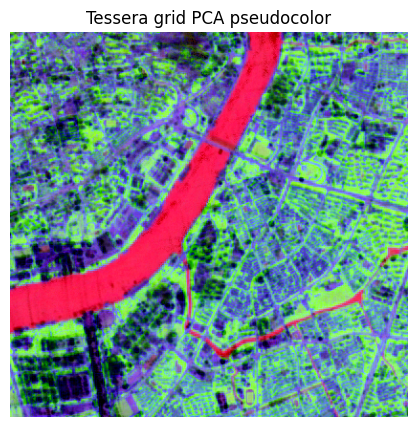

{'mean': array([ 3.1960571e+00, -2.8661504e+00, -1.2045557e+00,  4.0560160e+00,
        -1.0441488e+00, -1.5309714e+00, -1.6139755e+00, -1.2970990e+00,
        -4.0516379e-01,  1.8469477e+00, -1.2965550e-01,  3.1828473e+00,
         1.2677317e+00, -2.9585576e+00, -1.8621333e+00,  8.5151500e-01,
        -2.6369163e-01,  2.3083189e+00, -2.2967416e-01,  1.4172567e+00,
         3.0589025e+00,  1.9628842e+00,  2.0570407e+00, -1.6302434e+00,
         5.0134268e+00,  9.2652595e-01, -1.6763446e+00,  2.7555006e+00,
        -1.8487889e+00,  3.4271851e+00, -2.0356665e+00,  2.9067388e+00,
        -2.1346905e+00,  8.8696557e-01,  1.7524476e+00, -5.5445927e-01,
         3.6104107e+00,  5.1247752e-01,  5.8176544e-02, -1.0170799e+00,
         1.5882216e-01, -2.2565756e+00,  1.8190869e+00,  2.6467519e+00,
         4.8037684e-01,  3.4319597e-01,  1.2925552e-01, -1.6814635e+00,
         2.6798224e+00, -4.1041799e+00, -2.8956103e+00, -9.6349084e-01,
        -2.5181255e+00, -3.0912554e+00,  3.2475519e+00, 

<Figure size 640x480 with 0 Axes>

In [4]:
emb_tessera_grid = get_embedding(
    "tessera",
    spatial=spatial_point,#PointBuffer(lon=120.0, lat=30.0, buffer_m=2048),
    temporal=temporal_year,
    output=OutputSpec.grid(),
    backend="local",
)

print("data.shape:", emb_tessera_grid.data.shape)
print("meta keys:", list(emb_tessera_grid.meta.keys()))

plot_embedding_pseudocolor(
    emb_tessera_grid,
    title="Tessera grid PCA pseudocolor",
)

## 3. On-the-fly model: `remoteclip_s2rgb`

### 3.1 Pooled output
- Spatial: `PointBuffer`
- Temporal: date range
- Output: `pooled(mean)`


In [5]:
emb_remoteclip_pooled = get_embedding(
    "remoteclip_s2rgb",
    spatial=spatial_point,
    temporal=temporal_range,
    output=OutputSpec.pooled(),
)

print("data.shape:", emb_remoteclip_pooled.data.shape)
print("model:", emb_remoteclip_pooled.meta.get("model"))

print(json.dumps(emb_remoteclip_pooled.meta, indent=2)[:1500])

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights from local directory
data.shape: (768,)
model: remoteclip_s2rgb
{
  "model": "remoteclip_s2rgb",
  "type": "on_the_fly",
  "backend": "gee",
  "source": "COPERNICUS/S2_SR_HARMONIZED",
  "sensor": {
    "collection": "COPERNICUS/S2_SR_HARMONIZED",
    "bands": [
      "B4",
      "B3",
      "B2"
    ],
    "scale_m": 10,
    "cloudy_pct": 30,
    "composite": "median"
  },
  "temporal": {
    "mode": "range",
    "start": "2022-06-01",
    "end": "2022-09-01"
  },
  "input_time": "2022-07-17",
  "image_size": 224,
  "bands": [
    "B4",
    "B3",
    "B2"
  ],
  "scale_m": 10,
  "cloudy_pct": 30,
  "composite": "median",
  "start": "2022-06-01",
  "end": "2022-09-01",
  "ckpt": "MVRL/remote-clip-vit-base-patch32",
  "device": "cpu",
  "pretrained_required": true,
  "auto_download": true,
  "hf_cache_dir": null,
  "ckpt_input": "MVRL/remote-clip-vit-base-patch32",
  "ckpt_local_dir": "/u/dingqi2/.cache/huggingface/hub/models--MVRL--remote-clip-vit-base-patch32/snapshots/

### 3.2 Grid output

/u/dingqi2/miniconda3/envs/torchgeo/lib/python3.12/site-packages/torch/cuda/__init__.py:1007: UserWarning: Can't initialize NVML
  raw_cnt = _raw_device_count_nvml()
/u/dingqi2/miniconda3/envs/torchgeo/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/u/dingqi2/miniconda3/envs/torchgeo/lib/python3.12/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4381.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


load checkpoint success from: /u/dingqi2/.cache/rs_embed/agrifm/AgriFM.pth
data.shape: (1024, 14, 14)
grid_hw: (14, 14)


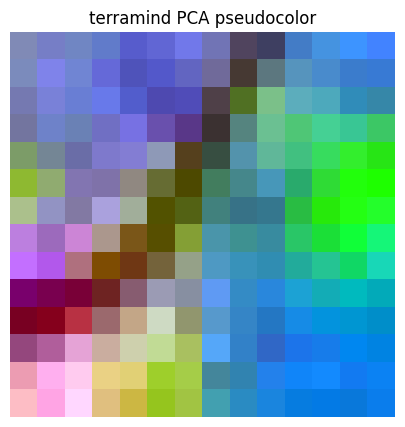

{'mean': array([ 0.82095957,  1.9205673 ,  0.18216462, ..., -0.9978347 ,
        -0.67275363,  0.07550099], shape=(1024,), dtype=float32),
 'components': array([[ 0.02024409, -0.05027563,  0.02490875, ...,  0.06019177,
          0.00921867,  0.06173358],
        [-0.00255468, -0.00124767, -0.02374833, ..., -0.03526751,
         -0.03634357, -0.02094801],
        [-0.05611954, -0.09004604, -0.04230499, ...,  0.01501518,
         -0.00959107, -0.0524384 ]], shape=(3, 1024), dtype=float32),
 'center': True}

<Figure size 640x480 with 0 Axes>

In [4]:
emb_remoteclip_grid = get_embedding(
    "agrifm", #terramind
    spatial=spatial_point,
    temporal=temporal_range,
    output=OutputSpec.grid()
)

print("data.shape:", emb_remoteclip_grid.data.shape)
print("grid_hw:", emb_remoteclip_grid.meta.get("grid_hw"))

plot_embedding_pseudocolor(
    emb_remoteclip_grid,
    title="terramind PCA pseudocolor"
)

## 4. Get Embedding Batches

In [7]:
from rs_embed import BBox, PointBuffer, TemporalSpec, OutputSpec, get_embedding
from plot_utils import *

import json
from rs_embed import BBox, get_embeddings_batch

points = [
    PointBuffer(lon=121.5, lat=31.2, buffer_m=100),
    PointBuffer(lon=121.6, lat=31.3, buffer_m=100),
    PointBuffer(lon=120.0, lat=30.0, buffer_m=100),
]

embeddings = get_embeddings_batch(
    "satmae_rgb",
    # "tessera",
    spatials=points,
    temporal=TemporalSpec.year(2024),#range("2021-06-01", "2021-08-31"), #
    output=OutputSpec.grid(),
    backend="gee"
)

for i, emb in enumerate(embeddings):
    print(f"Embedding {i} shape: {emb.data.shape}")


/u/dingqi2/miniconda3/envs/torchgeo/lib/python3.12/site-packages/torch/cuda/__init__.py:1007: UserWarning: Can't initialize NVML
  raw_cnt = _raw_device_count_nvml()


Embedding 0 shape: (1024, 14, 14)
Embedding 1 shape: (1024, 14, 14)
Embedding 2 shape: (1024, 14, 14)


## 5. `inspect_gee_patch` in 20 seconds
- One call to check downloaded input quality before embedding.
- Then show quantiles, histogram, and quicklook image.


In [4]:
from rs_embed import SensorSpec, TemporalSpec, inspect_gee_patch

check_out = inspect_gee_patch(
    spatial=spatial_point,
    temporal=TemporalSpec.range("2022-06-01", "2022-09-01"),
    sensor=SensorSpec(
        collection="COPERNICUS/S2_SR_HARMONIZED",
        bands=("B4", "B3", "B2"),
        scale_m=10,
        cloudy_pct=10,
        composite="median",
        fill_value=0.0,
        check_save_dir="./_gee_checks",
    ),
    value_range=(0, 10000),
)

print("ok:", check_out.get("ok"))


ok: True


band_quantiles (first 3 bins):
{'p01': [112.0, 237.0, 0.0], 'p50': [1064.0, 1034.0, 756.0], 'p99': [5128.0, 5068.0, 4896.0]}


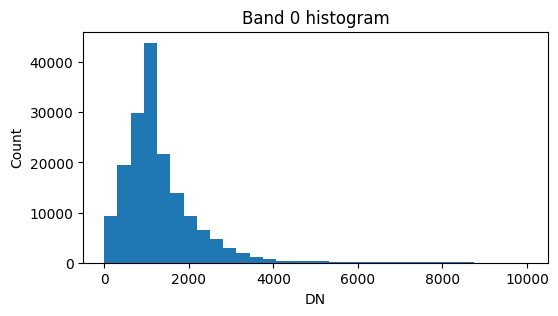

In [5]:
from plot_utils import print_band_quantiles_preview, plot_histogram_from_report

report = check_out.get("report") or {}
print_band_quantiles_preview(report, n_preview=3)
plot_histogram_from_report(report, band_index=0, figsize=(6, 3))


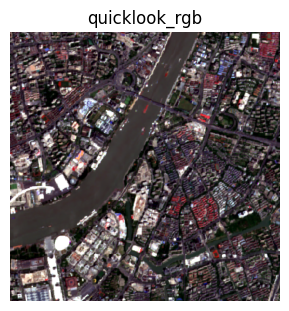

In [6]:
from plot_utils import show_quicklook_artifact

show_quicklook_artifact(check_out.get("artifacts") or {})


## 6. `export_batch()` in 30 seconds
- Minimal example: export multi-point inputs + embeddings + manifest.
- Then inspect one file with a single helper call.


In [11]:
from rs_embed import PointBuffer, TemporalSpec, OutputSpec, export_batch

export_batch(
    out_dir="exports",
    names=["p1", "p2"],
    spatials=[
        PointBuffer(lon=121.5, lat=31.2, buffer_m=200),
        PointBuffer(lon=120.5, lat=30.2, buffer_m=200),
    ],
    temporal=TemporalSpec.range("2022-06-01", "2022-09-01"),
    models=["remoteclip_s2rgb", "prithvi_eo_v2_s2_6b"],
    output=OutputSpec.pooled(),
    save_inputs=True,
)


export_batch:   0%|          | 0/2 [00:00<?, ?point/s]

infer[remoteclip_s2rgb]:   0%|          | 0/2 [00:00<?, ?point/s]

infer[prithvi_eo_v2_s2_6b]:   0%|          | 0/2 [00:00<?, ?point/s]

/u/dingqi2/miniconda3/envs/torchgeo/lib/python3.12/site-packages/torch/cuda/__init__.py:1007: UserWarning: Can't initialize NVML
  raw_cnt = _raw_device_count_nvml()


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights from local directory


/u/dingqi2/miniconda3/envs/torchgeo/lib/python3.12/site-packages/torch/cuda/__init__.py:1007: UserWarning: Can't initialize NVML
  raw_cnt = _raw_device_count_nvml()


[{'created_at': '2026-02-20T23:08:14Z',
  'point_index': 0,
  'status': 'ok',
  'backend': 'gee',
  'device': 'auto',
  'models': [{'model': 'remoteclip_s2rgb',
    'status': 'ok',
    'sensor': {'collection': 'COPERNICUS/S2_SR_HARMONIZED',
     'bands': ['B4', 'B3', 'B2'],
     'scale_m': 10,
     'cloudy_pct': 30,
     'fill_value': 0.0,
     'composite': 'median',
     'check_input': False,
     'check_raise': True,
     'check_save_dir': None},
    'describe': {'type': 'on_the_fly',
     'backend': ['provider'],
     'inputs': {'collection': 'COPERNICUS/S2_SR_HARMONIZED',
      'bands': ['B4', 'B3', 'B2']},
     'temporal': {'mode': 'range'},
     'output': ['pooled', 'grid'],
     'defaults': {'scale_m': 10,
      'cloudy_pct': 30,
      'composite': 'median',
      'ckpt': 'MVRL/remote-clip-vit-base-patch32',
      'image_size': 224},
     'notes': 'grid output is ViT token grid (patch-level), typically 7x7 for ViT-B/32 at 224px.'},
    'input': {'npz_key': 'input_chw__remoteclip

Inspect one exported file (read + summary + exact input visualization)


=== Manifest summary ===
npz_path: None
backend: gee
spatial: {'lon': 121.5, 'lat': 31.2, 'buffer_m': 200, 'crs': 'EPSG:4326'}
temporal: {'mode': 'range', 'year': '<function TemporalSpec.year at 0x150989c6d580>', 'start': '2022-06-01', 'end': '2022-09-01'}
npz_keys: ['input_chw__remoteclip_s2rgb', 'embedding__remoteclip_s2rgb', 'input_chw__prithvi_eo_v2_s2_6b', 'embedding__prithvi_eo_v2_s2_6b']

=== model -> input key ===
remoteclip_s2rgb: input_chw__remoteclip_s2rgb
prithvi_eo_v2_s2_6b: input_chw__prithvi_eo_v2_s2_6b

=== Visualizing exact model inputs ===
input_chw__remoteclip_s2rgb <- remoteclip_s2rgb shape=(3, 41, 41) dtype=float32 min=0 max=3.35e+03


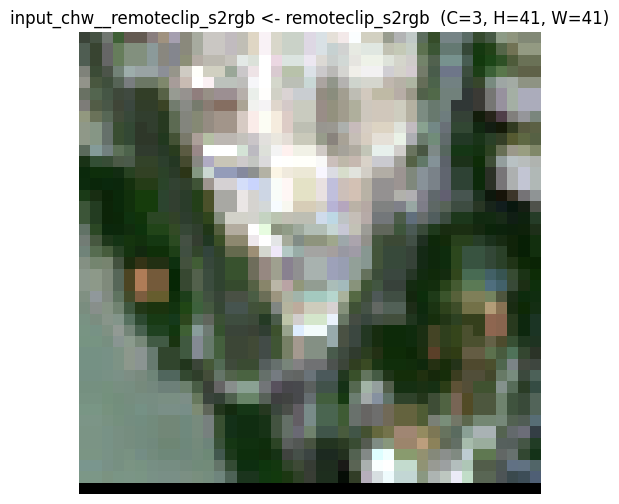

input_chw__prithvi_eo_v2_s2_6b <- prithvi_eo_v2_s2_6b shape=(6, 41, 41) dtype=float32 min=0 max=4.57e+03


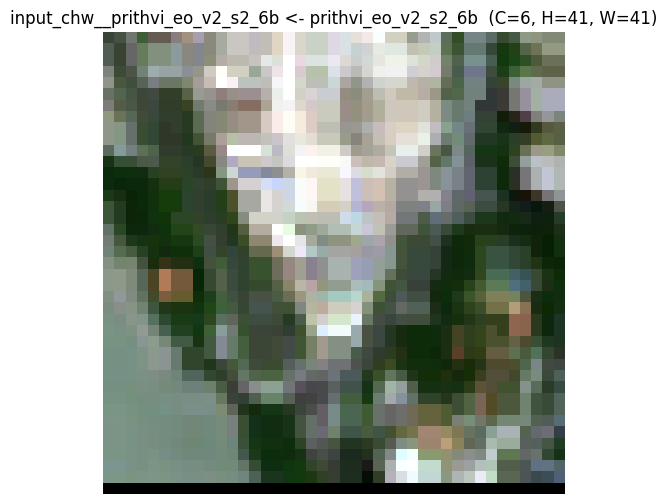

In [12]:
from plot_utils import inspect_export_npz

manifest, z = inspect_export_npz("exports/p1.npz")
